<a href="https://colab.research.google.com/github/shunitavni/This-Fish-Doesnt-exist/blob/master/Deep_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__
!pip install imageio
!pip install h5py pyyaml
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tqdm import tqdm
from google.colab import drive
from IPython import display
import cv2

drive.mount('/content/drive')




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
TARGET_IMG_WIDTH = 320
TARGET_IMG_HEIGHT = 140

def load_images(directory, label, limit=9999):
  """ loading images from given directory to MEMORY
  Arguments:
    directory: the path to the directory to load the images from
    label: label of the loaded images (all images loaded assumed to have the same label)
    limit: limit the number of images loaded
  """
  images = []
  labels = []
  for c,i in enumerate(tqdm(os.listdir(directory))):
      path = os.path.join(directory, i)
      img = cv2.imread(path, cv2.IMREAD_COLOR)
     
      if img is not None:
          #img = cv2.resize(img, (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT))
          images.append(np.array(img))
          labels.append(label)
      if c > limit:
          break
  return np.array(images),np.array(labels)

train_images,train_labels = load_images('/content/drive/My Drive/fish_images',0.95)

train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 4415
BATCH_SIZE = 64


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

100%|██████████| 4415/4415 [29:29<00:00,  2.49it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 716800)            71680000  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 716800)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 716800)            2867200   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 716800)            0         
_________________________________________________________________
reshape (Reshape)            (None, 35, 80, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 35, 80, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 80, 128)       5

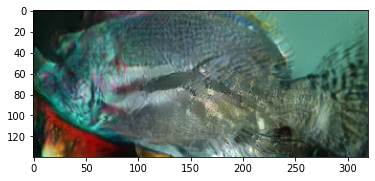

In [ ]:


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(80*35*256, use_bias=False, input_shape=(100,)))
    model.add(layers.GaussianNoise(0.01))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((35, 80, 256)))
    assert model.output_shape == (None, 35, 80, 256)  
                                                    

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 35,80, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 35, 80, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 70, 160, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 140, 320, 3)

    return model

generator = make_generator_model()

generator.load_weights('/content/drive/My Drive/deeperGanCheckpoint_small_lr/gen_copy_checkpoint')

print(generator.summary())
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(((np.uint8(generated_image * 127.5 + 127.5))[0, :, :,::-1]))




In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[140, 320, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
discriminator.load_weights('/content/drive/My Drive/deeperGanCheckpoint_small_lr/dis_copy_checkpoint')
print(discriminator.summary())
decision = discriminator(generated_image) # we give to the D a generated img from the generator
print (decision) # decision if its fake or real

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 160, 64)       4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 70, 160, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 160, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 160, 64)       102464    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 70, 160, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 160, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 160, 128)     

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
EPOCHS = 3000
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier to spot changes)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# This annotation causes the function to be "compiled" - fast running
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    if (gen_loss / disc_loss) > 2:
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
   for epoch in range(epochs):
    start = time.time()
    tgl = 0
    tdl = 0
    i = 0
    for image_batch in dataset:
      gl, dl = train_step(image_batch)
      tgl = tgl + gl #total loss-gen
      tdl = tdl + dl #total loss- disc
      i = i + 1

    
    if (epoch + 1) % 20 == 0:
      # Save the weights once in 20 epochs
      generator.save_weights('/content/drive/My Drive/deeperGanCheckpoint_small_lr/gen_copy_checkpoint')
      discriminator.save_weights('/content/drive/My Drive/deeperGanCheckpoint_small_lr/dis_copy_checkpoint')
  

    if (epoch +1) % 10 == 0:
      #draw the seed images to visualize progress
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               seed)


    tgl = tgl / i
    tdl = tdl / i
    print ('Time for epoch {} is {} sec . gen loss {} . dis loss {}'.format(epoch + 1, time.time()-start,tgl,tdl))


  # Generate after the final epoch
   display.clear_output(wait=True)
   generate_and_save_images(generator,
                           epochs,
                           seed)

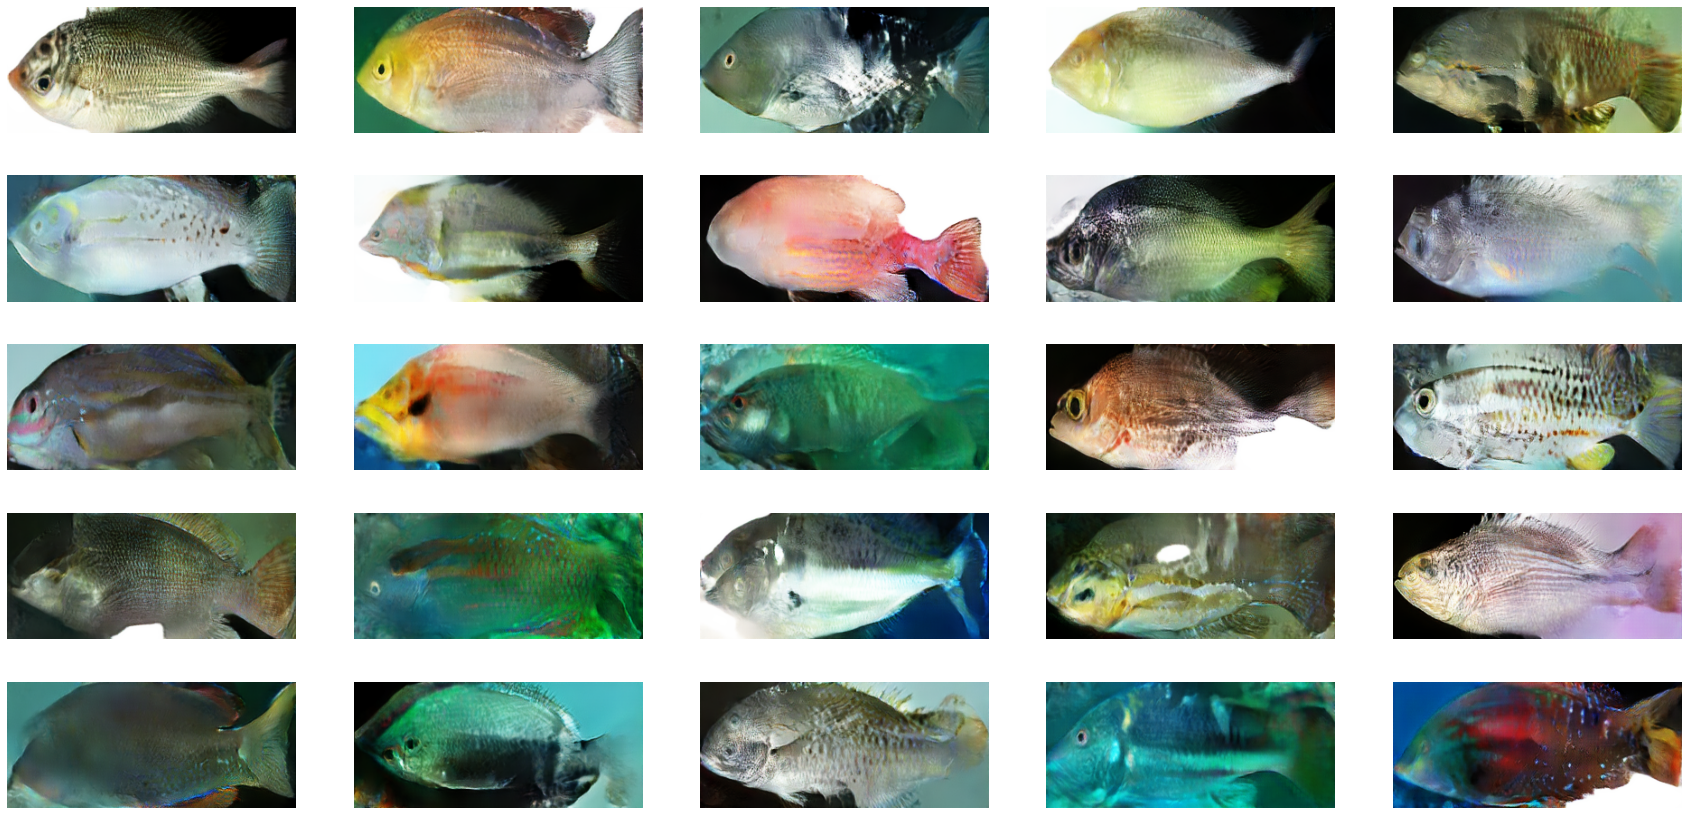

Time for epoch 210 is 30.869067907333374 sec . gen loss 1.776320219039917 . dis loss 0.726980447769165
Time for epoch 211 is 28.870277404785156 sec . gen loss 1.7813960313796997 . dis loss 0.7295128703117371
Time for epoch 212 is 28.85030484199524 sec . gen loss 1.7747621536254883 . dis loss 0.730445921421051
Time for epoch 213 is 28.837954998016357 sec . gen loss 1.7589621543884277 . dis loss 0.7350544333457947
Time for epoch 214 is 28.842328548431396 sec . gen loss 1.7511255741119385 . dis loss 0.7466561794281006
Time for epoch 215 is 28.818140029907227 sec . gen loss 1.7787951231002808 . dis loss 0.7381636500358582
Time for epoch 216 is 28.839961290359497 sec . gen loss 1.7578872442245483 . dis loss 0.7421703338623047
Time for epoch 217 is 28.812339782714844 sec . gen loss 1.7886669635772705 . dis loss 0.7323247790336609


In [ ]:
def generate_and_save_images(model, epoch, test_input):  
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(30,15))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(((np.uint8(predictions * 127.5 + 127.5))[i, :, :,::-1]))
      plt.axis('off')
  plt.show()

train(train_dataset, EPOCHS)



In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
display.clear_output(wait=True)
generate_and_save_images(generator,
                         4,
                         seed)